In [105]:
import pandas as pd
import numpy as np
import ast
import json
import pickle

from sklearn.linear_model import LinearRegression as LR
from sklearn.naive_bayes import CategoricalNB as CatNB
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error

## Loading training data

In [106]:
# reads string and evaluates str(string), if true then it will return back the string
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return


# reads json files, for features, from outputs of other notebooks
# name update dictionaries 
with open('params/investor_country_name_grouping.json') as json_file:
    investor_country_name_dict = json.load(json_file)

with open('params/startup_country_name_grouping.json') as json_file:
    startup_country_name_dict = json.load(json_file)

with open('params/investor_name_grouping.json') as json_file:
    investor_name_dict = json.load(json_file)


# index dictionaries
with open('params/rounds_index.json') as json_file:
    rounds_index = json.load(json_file)

with open('params/investor_country_round_index.json') as json_file:
    investor_country_round_index = json.load(json_file)

with open('params/startup_country_round_index.json') as json_file:
    startup_country_round_index = json.load(json_file)

with open('params/investors_rounds.json') as json_file:
    investors_rounds_index = json.load(json_file)

In [107]:
data = pd.read_csv('splitted data/rounds_testing.csv') # dataframe from the training dataset of the rounds csv
investment = pd.read_csv('splitted data/investments_testing.csv') # investment dataset dataframe

In [108]:
data = data[data['raised_amount_usd'].notnull()].copy() # removing nulls
data = data[data['raised_amount_usd'] >= 50000].copy() # arbitrary threshold for the funding
data.shape

(17684, 13)

In [109]:
# merge the investment dataframe with rounds dataframe
data_merged = data.merge(investment[['investor_name', 'investor_country_code', 'funding_round_permalink']]
                ,how = 'inner', on = 'funding_round_permalink')
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,seed,Nexus Venture Partners,USA
1,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Capital One,USA
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Nexus Venture Partners,USA
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Paxion Capital Partners,NaN
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Transamerica,USA


In [110]:
data_merged = data_merged[data_merged['investor_country_code'].notnull()] # removes nulls
data_merged.shape

(23472, 15)

## 1.1. Applying Investor Country Name grouping

In [111]:
# merge investor_country_code with the dictionary from the json files, which will replace countries to "OTHER"
data_merged = data_merged[data_merged['investor_country_code'].isin(investor_country_name_dict['investor_country_name_new'].keys())].copy()
data_merged.loc[:,'investor_country_code'] = data_merged['investor_country_code'].apply(lambda x: investor_country_name_dict['investor_country_name_new'][x])
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,seed,Nexus Venture Partners,USA
1,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Capital One,USA
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Nexus Venture Partners,USA
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Transamerica,USA
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0,venture,Nexus Venture Partners,USA


In [112]:
# Dropping OTHERs from the investor country code
data_merged = data_merged[data_merged["investor_country_code"]!="OTHER"]

## 1.2. Applying Investor Name grouping

In [113]:
# update some investor names as 'Other'
data_merged = data_merged[data_merged['investor_name'].isin(investor_name_dict.keys())].copy()
data_merged.loc[:,'investor_name'] = data_merged['investor_name'].apply(lambda x: investor_name_dict[x])
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,seed,Nexus Venture Partners,USA
1,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Capital One,USA
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Nexus Venture Partners,USA
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0,venture,Nexus Venture Partners,USA
6,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0,venture,Other,USA


In [114]:
# Dropping Other from the investor name
data_merged = data_merged[data_merged["investor_name"]!="Other"]

## 2.1. Creating Investor Country & Round Index feature

In [115]:
# creates the index data frame from the dictionary from the json file
investor_country_round_index = pd.DataFrame.from_dict(investor_country_round_index, orient='index')

# calls the previously defined "parse_tuple" function to parse through 
investor_country_round_index.index = [parse_tuple(item) for item in list(investor_country_round_index.index)]


investor_country_round_index.index = pd.MultiIndex.from_tuples(investor_country_round_index.index)
investor_country_round_index.index.names = ['country', 'round']
print(investor_country_round_index)

                              0
country round                  
ARG     angel                 1
        convertible_note      1
        product_crowdfunding  3
        seed                  1
        undisclosed           2
...                          ..
USA     venture D             8
        venture E             8
        venture F             9
        venture G             9
        venture H             9

[521 rows x 1 columns]


In [116]:
data_merged['inv_cntry_code_fund_round'] = list(zip(data_merged['investor_country_code'], data_merged['funding_round']))

In [117]:
#since searching in dictionary objects are way faster, index df is converted to dict
investor_country_round_index_dict = investor_country_round_index.to_dict()[0]

# udf to be applied to df's rows
def inv_country_rnd_idx(row):
    country = row['investor_country_code']
    round_ = row['funding_round']

    search_key = tuple((country, round_))
    
    value = investor_country_round_index_dict[search_key]
    
    return int(value)
    #return int(a.values[0])
    
data_merged = data_merged[data_merged['inv_cntry_code_fund_round'].isin(investor_country_round_index_dict.keys())].copy()
data_merged['investor_country_round_index'] = data_merged.apply(inv_country_rnd_idx, axis = 1)
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,inv_cntry_code_fund_round,investor_country_round_index
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,seed,Nexus Venture Partners,USA,"(USA, seed)",2
1,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Capital One,USA,"(USA, venture B)",7
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Nexus Venture Partners,USA,"(USA, venture B)",7
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0,venture,Nexus Venture Partners,USA,"(USA, venture)",8
8,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,2014-07-19,8900000.0,venture A,Nexus Venture Partners,USA,"(USA, venture A)",5


## 2.2. Creating Investor & Round Index feature

In [118]:
investors_rounds_index = pd.DataFrame.from_dict(investors_rounds_index, orient='index')
investors_rounds_index.index = [parse_tuple(item) for item in list(investors_rounds_index.index)]
investors_rounds_index.index = pd.MultiIndex.from_tuples(investors_rounds_index.index)
investors_rounds_index.index.names = ['investor', 'round']
investors_rounds_index

investors_rounds_index_dict = investors_rounds_index.to_dict()[0]

data_merged['inv_fund_round'] = list(zip(data_merged['investor_name'], data_merged['funding_round']))

# udf to be applied to df's rows
def inv_rnd_idx(row):
    investor = row['investor_name']
    round_ = row['funding_round']
    
    search_key = tuple((investor, round_))

    value = investors_rounds_index_dict[search_key]
    if value == None:
        value = 1
    return int(value)  

data_merged = data_merged[data_merged['inv_fund_round'].isin(investors_rounds_index_dict.keys())].copy()
data_merged['investors_round_index'] = data_merged.apply(inv_rnd_idx, axis = 1)
data_merged.head(50)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,inv_cntry_code_fund_round,investor_country_round_index,inv_fund_round,investors_round_index
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3000000.0,seed,Nexus Venture Partners,USA,"(USA, seed)",2,"(Nexus Venture Partners, seed)",3
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,20000000.0,venture B,Nexus Venture Partners,USA,"(USA, venture B)",7,"(Nexus Venture Partners, venture B)",8
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,1700000.0,venture,Nexus Venture Partners,USA,"(USA, venture)",8,"(Nexus Venture Partners, venture)",6
8,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,2014-07-19,8900000.0,venture A,Nexus Venture Partners,USA,"(USA, venture A)",5,"(Nexus Venture Partners, venture A)",6
14,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed,NaN,2014-02-05,150000.0,seed,Camp One Ventures,USA,"(USA, seed)",2,"(Camp One Ventures, seed)",3
15,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed,NaN,2014-02-05,150000.0,seed,Kima Ventures,FRA,"(FRA, seed)",2,"(Kima Ventures, seed)",2
16,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed,NaN,2014-02-05,150000.0,seed,Rick Marini,USA,"(USA, seed)",2,"(Rick Marini, seed)",2
18,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/e82464f22241715dd1a6c77241055ed1,seed,NaN,2011-07-20,1000050.0,seed,CRV,USA,"(USA, seed)",2,"(CRV, seed)",2
19,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/e82464f22241715dd1a6c77241055ed1,seed,NaN,2011-07-20,1000050.0,seed,General Catalyst Partners,USA,"(USA, seed)",2,"(General Catalyst Partners, seed)",3
20,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/e82464f22241715dd1a6c77241055ed1,seed,NaN,2011-07-20,1000050.0,seed,SV Angel,USA,"(USA, seed)",2,"(SV Angel, seed)",2


In [119]:
del data_merged['inv_cntry_code_fund_round'], data_merged['inv_fund_round']

## 3. Updating indexes with non unique values for each startup and round pair
In one investment round, there might be more than one investor companies. This means for each startup company and round pair, investor country round index and investor round index might not be unique. To represent these indexes, an aggragation is applied as grouping each startup company and round pair, updating these index features with mean index value.

In [120]:
data_merged_grouped = data_merged.groupby(['funding_round_permalink'])\
                    .agg({'investor_country_round_index': 'mean',
                          'investors_round_index': 'mean'}).round()
del data_merged['investor_country_round_index'], data_merged['investors_round_index']
data_merged = data_merged.merge(data_merged_grouped, how = 'left', left_on = 'funding_round_permalink', right_index=True)
data_merged['investor_country_round_index'] = data_merged['investor_country_round_index'].astype(int)
data_merged['investors_round_index'] = data_merged['investors_round_index'].astype(int)
data_merged.tail(50)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,investor_country_round_index,investors_round_index
28698,/organization/zoomsystems,ZoomSystems,Hardware + Software,USA,CA,SF Bay Area,San Francisco,/funding-round/e5635260dca6a70e4401003b9b68546a,venture,B,2005-07-19,12000000.0,venture B,NeoCarta Ventures,USA,7,8
28699,/organization/zoomsystems,ZoomSystems,Hardware + Software,USA,CA,SF Bay Area,San Francisco,/funding-round/e5635260dca6a70e4401003b9b68546a,venture,B,2005-07-19,12000000.0,venture B,Sierra Ventures,USA,7,8
28700,/organization/zound-industries,Zound Industries,Electronics,SWE,26,Stockholm,Stockholm,/funding-round/ec88fe4c28ebd00fc7e6f6d0718fb8d5,venture,B,2015-07-03,11083197.0,venture B,Time for Growth,FRA,5,9
28701,/organization/zoyi,Zoyi,Advertising,KOR,11,Seoul,Seoul,/funding-round/72acefc39686b7bfe40f5070920c67ea,seed,NaN,2011-09-01,650000.0,seed,Stonebridge Capital,KOR,3,5
28702,/organization/zpower,ZPower,Batteries|Clean Technology|Medical Devices,USA,CA,Santa Barbara,Camarillo,/funding-round/889111c650699111ee55c9d1e22bdcc4,venture,NaN,2004-10-12,2000000.0,venture,Intel Capital,USA,8,6
28703,/organization/zpower,ZPower,Batteries|Clean Technology|Medical Devices,USA,CA,Santa Barbara,Camarillo,/funding-round/889111c650699111ee55c9d1e22bdcc4,venture,NaN,2004-10-12,2000000.0,venture,OnPoint Technologies,USA,8,6
28705,/organization/zqgame,ZQGame,Games,USA,CA,Los Angeles,El Segundo,/funding-round/774ca08b76d3d05dc8e5b2ac87efab0c,venture,A,2007-12-01,4220018.0,venture A,Shenzhen Capital Group,CHN,7,8
28706,/organization/zsx-medical,ZSX Medical,Health Care|Medical|Medical Devices,USA,PA,Philadelphia,Philadelphia,/funding-round/8b1b4b57a8a9b71629de1c91d1b9d1e2,seed,NaN,2015-05-06,250000.0,seed,Ben Franklin Technology Partners of Southeaste...,USA,2,1
28708,/organization/zuora,Zuora,Billing|SaaS|Software,USA,CA,SF Bay Area,Foster City,/funding-round/0edaa816114e5e932f9f47de992f36e6,venture,D,2011-11-16,36000000.0,venture D,Benchmark,USA,8,9
28709,/organization/zuora,Zuora,Billing|SaaS|Software,USA,CA,SF Bay Area,Foster City,/funding-round/0edaa816114e5e932f9f47de992f36e6,venture,D,2011-11-16,36000000.0,venture D,Greylock Partners,USA,8,9


In [121]:
# drops these columns because they are now indices
del data_merged['investor_name'], data_merged['investor_country_code']


In [122]:
# drop duplicates
data_merged.drop_duplicates(inplace=True)
data_merged.shape

(8167, 15)

## 4. Aggragating raised amount and index features by startup company and funding round
There might be more than one same round for a startup company (e.g. two seed rounds on different dates). An additional aggregation is required for raised amount and index features.

In [123]:
# groupsby company_permalink and funding_round_type
agg_fields = ['raised_amount_usd', 'investors_round_index', 'investor_country_round_index']
agg_dict = { key: 'mean' for key in agg_fields}
agg_dict

{'raised_amount_usd': 'mean',
 'investors_round_index': 'mean',
 'investor_country_round_index': 'mean'}

In [124]:
data_merged_grouped = (
    data_merged.groupby(["company_permalink", "funding_round"]).agg(agg_dict).round()
)
data_merged.drop(agg_fields, axis=1, inplace=True)

# merges back to the original dataframe
data_merged = data_merged.merge(
    data_merged_grouped,
    how="left",
    left_on=["company_permalink", "funding_round"],
    right_index=True,
)
for column in agg_fields:
    data_merged[column] = data_merged[column].astype(int)
data_merged.head(50)


,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funding_round,raised_amount_usd,investors_round_index,investor_country_round_index
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,seed,3000000,3,2
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,venture B,20000000,8,7
5,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/ae2a174c06517c2394aed45006322a7e,venture,NaN,2013-01-03,venture,1700000,6,8
8,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,2014-07-19,venture A,8900000,6,5
14,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed,NaN,2014-02-05,seed,575025,2,2
18,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/e82464f22241715dd1a6c77241055ed1,seed,NaN,2011-07-20,seed,575025,2,2
26,/organization/1000memories,1000memories,Curated Web,USA,CA,SF Bay Area,San Francisco,/funding-round/502bd0e50c27616995e4bdad24605ef8,venture,A,2011-02-16,venture A,2520000,4,5
37,/organization/117go,117go,Social Travel,CHN,23,Shanghai,Shanghai,/funding-round/bbbda407fa8638d944ecfdd042230c4b,venture,B,2014-04-28,venture B,20000000,10,8
40,/organization/121cast,121cast,Audio|Mobile|Music,AUS,7,Melbourne,Melbourne,/funding-round/4ff51088be233a23c013689d680f04e5,seed,NaN,2012-11-13,seed,250000,2,2
41,/organization/140-proof,140 Proof,Advertising|Big Data Analytics|Interest Graph,USA,CA,SF Bay Area,San Francisco,/funding-round/2dc9ff9c590200195228ce2e153a1423,venture,A,2009-07-01,venture A,3000000,7,5


In [125]:
# Dropping undisclosed and venture from funding_round

data_merged = data_merged[data_merged["funding_round"]!="undisclosed"]
data_merged = data_merged[data_merged["funding_round"]!="venture"]

In [126]:
# delete unnecessary columns
data_merged.drop(
    ['funding_round_type' , 'funding_round_code'],
    axis = 1,
    inplace = True
)

In [127]:
data_merged.drop_duplicates(inplace=True)

## 5. Discretizing raised amount usd column in to buckets of 10

In [128]:
funding_disc = pd.read_csv('params/funding_amount_discretization.csv')
funding_disc['1'] = funding_disc.shift(-1)
funding_disc = funding_disc.reset_index()
funding_disc['index'] = funding_disc['index'] + 1
funding_disc.loc[0,'0'] = 50000
funding_disc

,index,0,1
0,1,5.000000e+04,1.840000e+05
1,2,1.840000e+05,4.147046e+05
2,3,4.147046e+05,7.916469e+05
3,4,7.916469e+05,1.300000e+06
4,5,1.300000e+06,2.100000e+06
5,6,2.100000e+06,3.791804e+06
6,7,3.791804e+06,6.000000e+06
7,8,6.000000e+06,1.000000e+07
8,9,1.000000e+07,2.000000e+07
9,10,2.000000e+07,2.127194e+10


In [129]:
# udf to be applied to df's rows
def disc(value):
    bucket = funding_disc[(value >= funding_disc['0']) & (value < funding_disc['1'])]['index'].values[0]
    return bucket

data_merged['raised_amount_buckets'] = data_merged['raised_amount_usd'].apply(disc)

## 6. Creating Rounds index feature

In [130]:
data_merged['rounds_index'] = data_merged['funding_round'].apply(lambda x: rounds_index[x])

## 7. Creating Startup Company Country & Round index feature

In [131]:
# There are null values in company_country_code column. To create the index feature
# first a temp df is created by removing the rows including null values. Then, index
# is created.

data_tmp = data_merged[['company_permalink', 'company_country_code', 'funding_round_permalink','funding_round']].copy()
print(data_tmp.shape)
data_tmp.dropna(subset= ['company_country_code'], inplace = True)
print(data_tmp.shape)

(6662, 4)
(6342, 4)


In [132]:
# merge company_country_code with the dictionary from the json files, which will replace countries to "OTHER"
data_tmp = data_tmp[data_tmp['company_country_code'].isin(startup_country_name_dict['company_country_name_new'].keys())].copy()
data_tmp.loc[:,'company_country_code'] = data_tmp['company_country_code'].apply(lambda x: startup_country_name_dict['company_country_name_new'][x])
data_tmp.head()

,company_permalink,company_country_code,funding_round_permalink,funding_round
0,/organization/0xdata,USA,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed
2,/organization/0xdata,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture B
8,/organization/0xdata,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture A
14,/organization/1,USA,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed
18,/organization/1,USA,/funding-round/e82464f22241715dd1a6c77241055ed1,seed


In [133]:
# Drop OTHER from company country code
data_tmp = data_tmp[data_tmp["company_country_code"]!="OTHER"]

In [134]:
# creates the index data frame from the dictionary from the json file
startup_country_round_index = pd.DataFrame.from_dict(startup_country_round_index, orient='index')

# calls the previously defined "parse_tuple" function to parse through 
startup_country_round_index.index = [parse_tuple(item) for item in list(startup_country_round_index.index)]


startup_country_round_index.index = pd.MultiIndex.from_tuples(startup_country_round_index.index)
startup_country_round_index.index.names = ['country', 'round']
print(startup_country_round_index)

                           0
country round               
ARE     angel              1
        convertible_note   1
        grant              8
        private_equity    10
        seed               2
...                       ..
USA     venture D          8
        venture E          9
        venture F          9
        venture G          9
        venture H          8

[475 rows x 1 columns]


In [135]:
#since searching in dictionary objects are way faster, index df is converted to dict
startup_country_round_index_dict = startup_country_round_index.to_dict()[0]

In [136]:
# udf to be applied to df's rows
data_tmp['comp_cntry_code_fund_round'] = list(zip(data_tmp['company_country_code'], data_tmp['funding_round']))
def startup_country_rnd_idx(row):
    country = row['company_country_code']
    round_ = row['funding_round']

    search_key = tuple((country, round_))
    
    value = startup_country_round_index_dict[search_key]

    return int(value)
    
data_tmp = data_tmp[data_tmp['comp_cntry_code_fund_round'].isin(startup_country_round_index_dict.keys())].copy()
data_tmp['company_country_round_index'] = data_tmp.apply(startup_country_rnd_idx, axis = 1)
data_tmp['company_country_round_index'] = data_tmp['company_country_round_index'].astype(int)
data_tmp.head()

,company_permalink,company_country_code,funding_round_permalink,funding_round,comp_cntry_code_fund_round,company_country_round_index
0,/organization/0xdata,USA,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,"(USA, seed)",3
2,/organization/0xdata,USA,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture B,"(USA, venture B)",7
8,/organization/0xdata,USA,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture A,"(USA, venture A)",5
14,/organization/1,USA,/funding-round/03b975068632eba5bfdb937ec8c07a68,seed,"(USA, seed)",3
18,/organization/1,USA,/funding-round/e82464f22241715dd1a6c77241055ed1,seed,"(USA, seed)",3


In [137]:
data_tmp.drop(
    ['company_permalink', 'company_country_code', 'funding_round'],
    axis = 1,
    inplace = True
)
data_tmp.head()

,funding_round_permalink,comp_cntry_code_fund_round,company_country_round_index
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"(USA, seed)",3
2,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"(USA, venture B)",7
8,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"(USA, venture A)",5
14,/funding-round/03b975068632eba5bfdb937ec8c07a68,"(USA, seed)",3
18,/funding-round/e82464f22241715dd1a6c77241055ed1,"(USA, seed)",3


In [138]:
data_merged = data_merged.merge(
    data_tmp,
    how = 'left',
    on = 'funding_round_permalink'
)
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funded_at,funding_round,raised_amount_usd,investors_round_index,investor_country_round_index,raised_amount_buckets,rounds_index,comp_cntry_code_fund_round,company_country_round_index
0,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,2013-05-22,seed,3000000,3,2,6,1,"(USA, seed)",3.0
1,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,2015-11-09,venture B,20000000,8,7,10,5,"(USA, venture B)",7.0
2,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,2014-07-19,venture A,8900000,6,5,8,4,"(USA, venture A)",5.0
3,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/03b975068632eba5bfdb937ec8c07a68,2014-02-05,seed,575025,2,2,3,1,"(USA, seed)",3.0
4,/organization/1,One Inc.,Mobile,USA,CA,SF Bay Area,San Francisco,/funding-round/e82464f22241715dd1a6c77241055ed1,2011-07-20,seed,575025,2,2,3,1,"(USA, seed)",3.0


Since there are missing startup countries in the dataset, related index values would also be null.
Following reads the imputer regression model trained on training data and imputes missing values by predicting them.

In [139]:
mis_value_reg = pickle.load(open('./model objects/comp_country_miss_imputer_model.pkl', 'rb'))

In [140]:
data_merged["company_country_round_index_pred"] = mis_value_reg.predict(
    data_merged[
        ["investors_round_index", "investor_country_round_index", "rounds_index"]
    ]
)
data_merged[['company_country_round_index','company_country_round_index_pred']]

,company_country_round_index,company_country_round_index_pred
0,3.0,2.782944
1,7.0,7.089368
2,5.0,5.444354
3,3.0,2.767859
4,3.0,2.767859
...,...,...
6657,7.0,5.997549
6658,3.0,2.767859
6659,3.0,2.767859
6660,3.0,2.912204


Following block fills the missing 'company_country_round_index' values. If the index value is missing, then the predicted value is used to fill. If the predicted value is below 1, then it is set as 1. If the predicted value is greater than 10, it is set as 10. Otherwise, the actual prediction is used.

In [141]:
def comp_cntry_rnd_idx_missing_imputer(row):

    value = row["company_country_round_index"]
    value_pred = round(row["company_country_round_index_pred"])

    if np.isnan(value):
        if value_pred < 1:
            return 1
        elif value_pred > 10:
            return 10
        else:
            return value_pred
    else:
        return value


data_merged["company_country_round_index"] = data_merged.apply(
    comp_cntry_rnd_idx_missing_imputer, axis=1
)


In [142]:
data_merged["company_country_round_index"] = data_merged["company_country_round_index"].astype(int)
data_merged["rounds_index"] = data_merged["rounds_index"].astype(int)

## 8. Merge time features to the testing dataset

In [143]:
company_df = pd.read_csv('splitted data/companies_testing.csv')
company_df = company_df[company_df['first_funding_at'].notna()]
company_df = company_df[company_df['founded_at'].notna()]

company_df['first_funding_at'] = pd.to_datetime(company_df['first_funding_at'], errors='coerce').dropna()
company_df['last_funding_at'] = pd.to_datetime(company_df['last_funding_at'], errors='coerce').dropna()
company_df['founded_at'] = pd.to_datetime(company_df['founded_at'], errors='coerce').dropna()

current_date = "2015-12-04"
company_df['time_since_first_investment'] = (pd.to_datetime(current_date) - company_df['first_funding_at']).astype('timedelta64[D]')
company_df['time_since_last_investment'] = (pd.to_datetime(current_date) - company_df['last_funding_at']).astype('timedelta64[D]')
company_df['company_age'] = (pd.to_datetime(current_date) - company_df['founded_at']).astype('timedelta64[D]')

investment_time_difference = company_df['time_since_first_investment'] - company_df['time_since_last_investment']
company_df['avg_time_between_rounds'] = investment_time_difference/company_df['funding_rounds']

company_df[['permalink','time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']]

,permalink,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds
1,/organization/mad-street-den,308.0,308.0,829.0,0.000000
2,/organization/zilta,671.0,671.0,1067.0,0.000000
3,/organization/hyperactive-media-gmbh,3108.0,3108.0,3082.0,0.000000
4,/organization/ampy,606.0,43.0,1052.0,281.500000
5,/organization/baloonr,977.0,133.0,702.0,281.333333
...,...,...,...,...,...
13267,/organization/arria-nlg,750.0,750.0,1798.0,0.000000
13269,/organization/life-on-air,241.0,241.0,1067.0,0.000000
13271,/organization/99drones,315.0,315.0,702.0,0.000000
13272,/organization/fieldlens,1464.0,575.0,1465.0,222.250000


In [144]:
data_merged = data_merged.merge(
    company_df, how="inner", left_on="company_permalink", right_on="permalink"
)
data_merged = data_merged[
    [
        "funding_round_permalink",
        "company_permalink",
        "funding_round",
        "investors_round_index",
        "investor_country_round_index",
        "rounds_index",
        "company_country_round_index",
        "time_since_first_investment",
        "time_since_last_investment",
        "company_age",
        "avg_time_between_rounds",
        "raised_amount_buckets",
    ]
].copy()
data_merged.drop_duplicates(inplace=True)


In [145]:
columns = ['time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']
for column in columns:
    data_merged[column] = data_merged[column].apply(lambda x: 0 if x < 0 else x)

time_feat_min_max = pd.read_csv('params/time_feat_min_max.csv')
data_merged.describe()

,investors_round_index,investor_country_round_index,rounds_index,company_country_round_index,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds,raised_amount_buckets
count,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000,5650.000000
mean,5.602832,5.177522,4.006018,5.564779,2151.017168,1025.187080,3085.229027,272.697406,6.643363
std,2.830891,2.323879,2.118702,2.101125,1350.330178,1060.321947,2332.301465,226.596731,2.791269
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.000000,0.000000,1.000000
25%,3.000000,2.000000,1.000000,3.000000,1051.000000,261.000000,1525.000000,115.375000,5.000000
50%,6.000000,5.000000,4.000000,5.000000,1905.000000,602.500000,2528.000000,245.833333,7.000000
75%,8.000000,7.000000,5.000000,7.000000,3154.000000,1466.000000,3989.000000,392.800000,9.000000
max,10.000000,10.000000,10.000000,10.000000,7795.000000,7795.000000,41610.000000,2158.500000,10.000000


In [146]:
lower = 1
upper = 10
for column in columns:
    min_val = time_feat_min_max[time_feat_min_max['feat'] == column]['min'].values[0]
    max_val = time_feat_min_max[time_feat_min_max['feat'] == column]['max'].values[0]

    data_merged[column] = round(((upper - lower) * ((data_merged[column] - min_val) / (max_val - min_val))) + lower)


In [147]:
data_merged.dropna(inplace=True)

## 9. Creating Sector Round Index

In [148]:
def drop_dupes(x):
    """this function removes duplicates"""
    return list(dict.fromkeys(x))

# reads the csv from the manually edited categories to sectors
categories = pd.read_csv("params/company_categories.csv", header=None)
# creates the dictionary from the csv
sectors = categories.set_index(0).to_dict()[1]

In [149]:
rounds = pd.read_csv("splitted data/rounds_testing.csv")

In [150]:
# drops NaNs from the category list
rounds = rounds[rounds['company_category_list'].notna()]
# resets the index
rounds = rounds.reset_index(drop=True)
# new category list so it can be split
category_list = rounds['company_category_list']

In [151]:
categories_list = category_list.tolist()
categories = []
for i in range(len(categories_list)):
    if "|" in str(categories_list[i]):
        categories.append(categories_list[i].split('|')) # splits the categories in that row 
    else:
        categories.append([categories_list[i]]) # makes sure that all the types are consistent, i.e. a list. 

In [152]:
# drops the original category list
rounds.drop(columns='company_category_list',inplace=True)
# makes a new category list from the split one
rounds['company_category_list'] = categories

In [153]:
# changes categories into sectors
company_sector = rounds['company_category_list'].apply(lambda x: [sectors[x[i]] for i in range(len(x))])

In [154]:
# removes duplicates from the sectors
no_dupes_company_sector = company_sector.apply(lambda x: drop_dupes(x))

In [155]:
# applies back the company sector list to the main dataframe
rounds['company_sector'] = no_dupes_company_sector

In [156]:
sectors_list = no_dupes_company_sector

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binarized_sectors = mlb.fit_transform(sectors_list) 
binarized_sectors_column_names = mlb.classes_

pickle.dump(mlb, open('./model objects/sectors_binarizer_testing.pkl', 'wb'))

overall_categories = pd.DataFrame(data=binarized_sectors,columns=binarized_sectors_column_names)
overall_categories

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,1,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
22631,1,0,0,0,0,0,0,1,0,0,0
22632,1,0,0,0,0,0,0,1,0,0,0
22633,1,0,0,0,0,0,0,1,0,0,0
22634,1,1,0,0,0,0,0,1,0,0,0


In [157]:
final = pd.concat([rounds, overall_categories], axis=1)

### 9.1. "Communication Services" round index

In [158]:
with open('sectors json/sector_rounds_communication_services.json') as json_file:
    sector_rounds_communication_services_dict = json.load(json_file)

sector_rounds_communication_services_index = pd.DataFrame.from_dict(sector_rounds_communication_services_dict, orient='index')
sector_rounds_communication_services_index.index = [parse_tuple(item) for item in list(sector_rounds_communication_services_index.index)]

sector_rounds_communication_services_index.index = pd.MultiIndex.from_tuples(sector_rounds_communication_services_index.index)
sector_rounds_communication_services_index.index.names = ['communication_services', 'round']

sector_rounds_communication_services_index_dict = sector_rounds_communication_services_index.to_dict()[0]

def sec_rnd_communication_ix(row):
    sector = row['Communication Services']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_communication_services_index_dict[search_key]
        return int(value)

final['Communication_Services_round_index'] = final.apply(sec_rnd_communication_ix, axis=1)

### 9.2. "Consumer Discretionary" round index

In [159]:
with open('sectors json/sector_rounds_consumer_discretionary.json') as json_file:
    sector_rounds_consumer_discretionary_dict = json.load(json_file)

sector_rounds_consumer_discretionary_index = pd.DataFrame.from_dict(sector_rounds_consumer_discretionary_dict, orient='index')
sector_rounds_consumer_discretionary_index.index = [parse_tuple(item) for item in list(sector_rounds_consumer_discretionary_index.index)]

sector_rounds_consumer_discretionary_index.index = pd.MultiIndex.from_tuples(sector_rounds_consumer_discretionary_index.index)
sector_rounds_consumer_discretionary_index.index.names = ['consumer_discretionary', 'round']

sector_rounds_consumer_discretionary_index_dict = sector_rounds_consumer_discretionary_index.to_dict()[0]

def sec_rnd_consumer_discretionary_ix(row):
    sector = row['Consumer Discretionary']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_consumer_discretionary_index_dict[search_key]
        return int(value)

final['Consumer_Discretionary_round_index'] = final.apply(sec_rnd_consumer_discretionary_ix, axis=1)

### 9.3. "Consumer Staples" index

In [160]:
with open('sectors json/sector_rounds_consumer_staples.json') as json_file:
    sector_rounds_consumer_staples_dict = json.load(json_file)

sector_rounds_consumer_staples_index = pd.DataFrame.from_dict(sector_rounds_consumer_staples_dict, orient='index')
sector_rounds_consumer_staples_index.index = [parse_tuple(item) for item in list(sector_rounds_consumer_staples_index.index)]

sector_rounds_consumer_staples_index.index = pd.MultiIndex.from_tuples(sector_rounds_consumer_staples_index.index)
sector_rounds_consumer_staples_index.index.names = ['consumer_staples', 'round']

sector_rounds_consumer_staples_index_dict = sector_rounds_consumer_staples_index.to_dict()[0]

def sec_rnd_consumer_staples_ix(row):
    sector = row['Consumer Staples']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_consumer_staples_index_dict[search_key]
        return int(value)

final['Consumer_Staples_round_index'] = final.apply(sec_rnd_consumer_staples_ix, axis=1)

### 9.4. "Energy" index

In [161]:
with open('sectors json/sector_rounds_energy.json') as json_file:
    sector_rounds_energy_dict = json.load(json_file)

sector_rounds_energy_index = pd.DataFrame.from_dict(sector_rounds_energy_dict, orient='index')
sector_rounds_energy_index.index = [parse_tuple(item) for item in list(sector_rounds_energy_index.index)]

sector_rounds_energy_index.index = pd.MultiIndex.from_tuples(sector_rounds_energy_index.index)
sector_rounds_energy_index.index.names = ['energy', 'round']

sector_rounds_energy_index_dict = sector_rounds_energy_index.to_dict()[0]

def sec_rnd_energy_ix(row):
    sector = row['Energy']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_energy_index_dict[search_key]
        return int(value)

final['Energy_round_index'] = final.apply(sec_rnd_energy_ix, axis=1)

### 9.5. "Financials" index

In [162]:
with open('sectors json/sector_rounds_financials.json') as json_file:
    sector_rounds_financials_dict = json.load(json_file)

sector_rounds_financials_index = pd.DataFrame.from_dict(sector_rounds_financials_dict, orient='index')
sector_rounds_financials_index.index = [parse_tuple(item) for item in list(sector_rounds_financials_index.index)]

sector_rounds_financials_index.index = pd.MultiIndex.from_tuples(sector_rounds_financials_index.index)
sector_rounds_financials_index.index.names = ['financials', 'round']

sector_rounds_financials_index_dict = sector_rounds_financials_index.to_dict()[0]

def sec_rnd_financials_ix(row):
    sector = row['Financials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_financials_index_dict[search_key]
        return int(value)

final['Financials_round_index'] = final.apply(sec_rnd_financials_ix, axis=1)

### 9.6. "Health Care" index

In [163]:
with open('sectors json/sector_rounds_health_care.json') as json_file:
    sector_rounds_health_care_dict = json.load(json_file)

sector_rounds_health_care_index = pd.DataFrame.from_dict(sector_rounds_health_care_dict, orient='index')
sector_rounds_health_care_index.index = [parse_tuple(item) for item in list(sector_rounds_health_care_index.index)]

sector_rounds_health_care_index.index = pd.MultiIndex.from_tuples(sector_rounds_health_care_index.index)
sector_rounds_health_care_index.index.names = ['Health Care', 'round']

sector_rounds_health_care_index_dict = sector_rounds_health_care_index.to_dict()[0]

def sec_rnd_health_care_ix(row):
    sector = row['Health Care']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_health_care_index_dict[search_key]
        return int(value)

final['Health_Care_round_index'] = final.apply(sec_rnd_health_care_ix, axis=1)

### 9.7. "Industrials" index

In [164]:
with open('sectors json/sector_rounds_industrials.json') as json_file:
    sector_rounds_industrials_dict = json.load(json_file)

sector_rounds_industrials_index = pd.DataFrame.from_dict(sector_rounds_industrials_dict, orient='index')
sector_rounds_industrials_index.index = [parse_tuple(item) for item in list(sector_rounds_industrials_index.index)]

sector_rounds_industrials_index.index = pd.MultiIndex.from_tuples(sector_rounds_industrials_index.index)
sector_rounds_industrials_index.index.names = ['Industrials', 'round']

sector_rounds_industrials_index_dict = sector_rounds_industrials_index.to_dict()[0]

def sec_rnd_industrials_ix(row):
    sector = row['Industrials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_industrials_index_dict[search_key]
        return int(value)

final['Industrials_round_index'] = final.apply(sec_rnd_industrials_ix, axis=1)

### 9.8. "Information Technology" index

In [165]:
with open('sectors json/sector_rounds_information_technology.json') as json_file:
    sector_rounds_information_technology_dict = json.load(json_file)

sector_rounds_information_technology_index = pd.DataFrame.from_dict(sector_rounds_information_technology_dict, orient='index')
sector_rounds_information_technology_index.index = [parse_tuple(item) for item in list(sector_rounds_industrials_index.index)]

sector_rounds_information_technology_index.index = pd.MultiIndex.from_tuples(sector_rounds_information_technology_index.index)
sector_rounds_information_technology_index.index.names = ['Information Technology', 'round']

sector_rounds_information_technology_index_dict = sector_rounds_information_technology_index.to_dict()[0]

def sec_rnd_information_technology_ix(row):
    sector = row['Information Technology']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_information_technology_index_dict[search_key]
        return int(value)

final['Information_Technology_round_index'] = final.apply(sec_rnd_information_technology_ix, axis=1)

### 9.9. "Materials" index

In [166]:
with open('sectors json/sector_rounds_materials.json') as json_file:
    sector_rounds_materials_dict = json.load(json_file)

sector_rounds_materials_index = pd.DataFrame.from_dict(sector_rounds_materials_dict, orient='index')
sector_rounds_materials_index.index = [parse_tuple(item) for item in list(sector_rounds_materials_index.index)]

sector_rounds_materials_index.index = pd.MultiIndex.from_tuples(sector_rounds_materials_index.index)
sector_rounds_materials_index.index.names = ['Materials', 'round']

sector_rounds_materials_index_dict = sector_rounds_materials_index.to_dict()[0]

def sec_rnd_materials_ix(row):
    sector = row['Materials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_materials_index_dict[search_key]
        return int(value)

final['Materials_round_index'] = final.apply(sec_rnd_materials_ix, axis=1)

### 9.10. "Real Estate" index 

In [167]:
with open('sectors json/sector_rounds_real_estate.json') as json_file:
    sector_rounds_real_estate_dict = json.load(json_file)

sector_rounds_real_estate_index = pd.DataFrame.from_dict(sector_rounds_real_estate_dict, orient='index')
sector_rounds_real_estate_index.index = [parse_tuple(item) for item in list(sector_rounds_real_estate_index.index)]

sector_rounds_real_estate_index.index = pd.MultiIndex.from_tuples(sector_rounds_real_estate_index.index)
sector_rounds_real_estate_index.index.names = ['Real Estate', 'round']

sector_rounds_real_estate_index_dict = sector_rounds_real_estate_index.to_dict()[0]

def sec_rnd_real_estate_ix(row):
    sector = row['Real Estate']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_real_estate_index_dict[search_key]
        return int(value)

final['Real_Estate_round_index'] = final.apply(sec_rnd_real_estate_ix, axis=1)

### 9.11. "Utilities" index

In [168]:
with open('sectors json/sector_rounds_utilities.json') as json_file:
    sector_rounds_utilities_dict = json.load(json_file)

sector_rounds_utilities_index = pd.DataFrame.from_dict(sector_rounds_utilities_dict, orient='index')
sector_rounds_utilities_index.index = [parse_tuple(item) for item in list(sector_rounds_utilities_index.index)]

sector_rounds_utilities_index.index = pd.MultiIndex.from_tuples(sector_rounds_utilities_index.index)
sector_rounds_utilities_index.index.names = ['Utilities', 'round']

sector_rounds_utilities_index_dict = sector_rounds_utilities_index.to_dict()[0]

def sec_rnd_utilities_ix(row):
    sector = row['Utilities']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_real_estate_index_dict[search_key]
        return int(value)

final['Utilities_round_index'] = final.apply(sec_rnd_utilities_ix, axis=1)

In [169]:
final = final.loc[:,['funding_round_permalink','Communication_Services_round_index',
       'Consumer_Discretionary_round_index', 'Consumer_Staples_round_index',
       'Energy_round_index', 'Financials_round_index',
       'Health_Care_round_index', 'Industrials_round_index',
       'Information_Technology_round_index', 'Materials_round_index',
       'Real_Estate_round_index', 'Utilities_round_index']]


In [170]:
data_merged_final = data_merged.merge(final, how = 'left', on = 'funding_round_permalink')
data_merged_final.head()

,funding_round_permalink,company_permalink,funding_round,investors_round_index,investor_country_round_index,rounds_index,company_country_round_index,time_since_first_investment,time_since_last_investment,company_age,...,Consumer_Discretionary_round_index,Consumer_Staples_round_index,Energy_round_index,Financials_round_index,Health_Care_round_index,Industrials_round_index,Information_Technology_round_index,Materials_round_index,Real_Estate_round_index,Utilities_round_index
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,/organization/0xdata,seed,3,2,1,3,2.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,/organization/0xdata,venture B,8,7,5,7,2.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,/organization/0xdata,venture A,6,5,4,5,2.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,/organization/1,seed,2,2,1,3,2.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,/funding-round/e82464f22241715dd1a6c77241055ed1,/organization/1,seed,2,2,1,3,2.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 10. Prediction on testing dataset by using models trained on training dataset

In [171]:
data_merged_final.dropna(axis=0,inplace=True)
data_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5633 entries, 0 to 5649
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   funding_round_permalink             5633 non-null   object 
 1   company_permalink                   5633 non-null   object 
 2   funding_round                       5633 non-null   object 
 3   investors_round_index               5633 non-null   int64  
 4   investor_country_round_index        5633 non-null   int64  
 5   rounds_index                        5633 non-null   int64  
 6   company_country_round_index         5633 non-null   int64  
 7   time_since_first_investment         5633 non-null   float64
 8   time_since_last_investment          5633 non-null   float64
 9   company_age                         5633 non-null   float64
 10  avg_time_between_rounds             5633 non-null   float64
 11  raised_amount_buckets               5633 no

In [172]:
print('Shape Before: ', data_merged_final.shape)
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'debt_financing']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'grant']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'convertible_note']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'non_equity_assistance']
print('Shape After: ', data_merged_final.shape)

Shape Before:  (5633, 23)
Shape After:  (5351, 23)


In [173]:
X = data_merged_final[
    ["investors_round_index",
    "investor_country_round_index", "rounds_index", "company_country_round_index",
     'time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds',
       'Communication_Services_round_index',
       'Consumer_Discretionary_round_index', 'Consumer_Staples_round_index',
       'Energy_round_index', 'Financials_round_index',
       'Health_Care_round_index', 'Industrials_round_index',
       'Information_Technology_round_index', 'Materials_round_index',
       'Real_Estate_round_index', 'Utilities_round_index']
].copy()

for column in X.columns:
    X[column] = X[column].astype(int)

y = data_merged_final[
    'raised_amount_buckets'
]


reg = pickle.load(open('./model objects/regression_predictor_model.pkl', 'rb'))
naive_bayes = pickle.load(open('./model objects/naive_bayes_predictor_model.pkl', 'rb'))
svr = pickle.load(open('./model objects/support_vect_predictor_model.pkl', 'rb'))

y_hat_reg = reg.predict(X)
#y_hat_nb = naive_bayes.predict(X)
y_hat_svr = svr.predict(X)

## Dashboard data preparation

In [174]:
X_dash = data_merged_final[
    ["funding_round_permalink","investors_round_index",
    "investor_country_round_index", "rounds_index", "company_country_round_index",
     'time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds',
       'Communication_Services_round_index',
       'Consumer_Discretionary_round_index', 'Consumer_Staples_round_index',
       'Energy_round_index', 'Financials_round_index',
       'Health_Care_round_index', 'Industrials_round_index',
       'Information_Technology_round_index', 'Materials_round_index',
       'Real_Estate_round_index', 'Utilities_round_index']
].copy()

X_dash.set_index("funding_round_permalink", inplace = True)

for column in X_dash.columns:
    X_dash[column] = X_dash[column].astype(int)

y_dash = data_merged_final[
    ["funding_round_permalink",'raised_amount_buckets']
].copy()

y_dash.set_index("funding_round_permalink", inplace = True)

In [175]:
dtr_model = pickle.load(open('./model objects/decision_tree_model_best.pkl', 'rb'))
X_dash['prediction'] = dtr_model.predict(X_dash)
X_dash['prediction'] = X_dash['prediction'].round()
X_dash

,investors_round_index,investor_country_round_index,rounds_index,company_country_round_index,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds,Communication_Services_round_index,Consumer_Discretionary_round_index,Consumer_Staples_round_index,Energy_round_index,Financials_round_index,Health_Care_round_index,Industrials_round_index,Information_Technology_round_index,Materials_round_index,Real_Estate_round_index,Utilities_round_index,prediction
funding_round_permalink,,,,,,,,,,,,,,,,,,,,
/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,3,2,1,3,2,7,3,1,0,0,0,0,0,0,0,1,0,0,0,4.0
/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,8,7,5,7,2,7,3,1,0,0,0,0,0,0,0,5,0,0,0,9.0
/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,6,5,4,5,2,7,3,1,0,0,0,0,0,0,0,4,0,0,0,7.0
/funding-round/03b975068632eba5bfdb937ec8c07a68,2,2,1,3,2,7,3,1,0,0,0,0,0,0,0,1,0,0,0,4.0
/funding-round/e82464f22241715dd1a6c77241055ed1,2,2,1,3,2,7,3,1,0,0,0,0,0,0,0,1,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/funding-round/7b34004a3842dff9818cf0d8dad6a65a,3,5,4,5,1,7,3,1,4,0,0,0,0,0,0,4,0,0,0,4.0
/funding-round/24e8134882bf6c4dcc385abba0acd5d9,2,2,1,3,1,7,3,1,2,0,0,0,0,0,0,1,0,0,0,4.0
/funding-round/c9f5097b3617c7539aa47c8b448163be,2,2,1,3,1,7,3,1,2,0,0,0,0,0,0,1,0,0,0,4.0


In [176]:
X_dash['prediction'] = X_dash['prediction'].astype(int)
X_dash.reset_index(inplace=True)

In [177]:
intervals = funding_disc.head(10)
def make_intervals(row):
    if row['index'] != 10:       
        return "[ " + str(int(round(row['0']))) + " , " + str(int(round(row['1']))) + " )"
    else:
        return "[ " + str(int(round(row['0']))) + " , ... )"

intervals['interval'] = intervals.apply(make_intervals, axis = 1)
intervals = intervals[['index', 'interval']]
intervals

<ipython-input-177-9aebdeaaf196>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervals['interval'] = intervals.apply(make_intervals, axis = 1)


,index,interval
0,1,"[ 50000 , 184000 )"
1,2,"[ 184000 , 414705 )"
2,3,"[ 414705 , 791647 )"
3,4,"[ 791647 , 1300000 )"
4,5,"[ 1300000 , 2100000 )"
5,6,"[ 2100000 , 3791804 )"
6,7,"[ 3791804 , 6000000 )"
7,8,"[ 6000000 , 10000000 )"
8,9,"[ 10000000 , 20000000 )"
9,10,"[ 20000000 , ... )"


In [178]:
X_dash = X_dash.merge(intervals, how = 'left' , left_on = 'prediction', right_on='index' )
X_dash

,funding_round_permalink,investors_round_index,investor_country_round_index,rounds_index,company_country_round_index,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds,Communication_Services_round_index,...,Financials_round_index,Health_Care_round_index,Industrials_round_index,Information_Technology_round_index,Materials_round_index,Real_Estate_round_index,Utilities_round_index,prediction,index,interval
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,3,2,1,3,2,7,3,1,0,...,0,0,0,1,0,0,0,4,4,"[ 791647 , 1300000 )"
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,8,7,5,7,2,7,3,1,0,...,0,0,0,5,0,0,0,9,9,"[ 10000000 , 20000000 )"
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,6,5,4,5,2,7,3,1,0,...,0,0,0,4,0,0,0,7,7,"[ 3791804 , 6000000 )"
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,2,2,1,3,2,7,3,1,0,...,0,0,0,1,0,0,0,4,4,"[ 791647 , 1300000 )"
4,/funding-round/e82464f22241715dd1a6c77241055ed1,2,2,1,3,2,7,3,1,0,...,0,0,0,1,0,0,0,4,4,"[ 791647 , 1300000 )"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,3,5,4,5,1,7,3,1,4,...,0,0,0,4,0,0,0,4,4,"[ 791647 , 1300000 )"
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,2,2,1,3,1,7,3,1,2,...,0,0,0,1,0,0,0,4,4,"[ 791647 , 1300000 )"
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,2,2,1,3,1,7,3,1,2,...,0,0,0,1,0,0,0,4,4,"[ 791647 , 1300000 )"
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,3,2,2,3,1,7,3,1,0,...,0,0,0,2,0,0,0,4,4,"[ 791647 , 1300000 )"


In [179]:
X_dash_2 = X_dash[['funding_round_permalink' , 'interval']].copy()
X_dash_2

,funding_round_permalink,interval
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"[ 791647 , 1300000 )"
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"[ 10000000 , 20000000 )"
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"[ 3791804 , 6000000 )"
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,"[ 791647 , 1300000 )"
4,/funding-round/e82464f22241715dd1a6c77241055ed1,"[ 791647 , 1300000 )"
...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,"[ 791647 , 1300000 )"
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,"[ 791647 , 1300000 )"
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,"[ 791647 , 1300000 )"
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,"[ 791647 , 1300000 )"


In [180]:
X_dash_3 = X_dash_2.merge(
    rounds[
        [
            "funding_round_permalink",
            "company_permalink",
            "funding_round",
            "company_country_code",
            "company_sector",
        ]
    ]
    , how = 'left'
    , on = "funding_round_permalink"
)
X_dash_3


,funding_round_permalink,interval,company_permalink,funding_round,company_country_code,company_sector
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"[ 791647 , 1300000 )",/organization/0xdata,seed,USA,[Information Technology]
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"[ 10000000 , 20000000 )",/organization/0xdata,venture B,USA,[Information Technology]
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"[ 3791804 , 6000000 )",/organization/0xdata,venture A,USA,[Information Technology]
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology]
4,/funding-round/e82464f22241715dd1a6c77241055ed1,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology]
...,...,...,...,...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,"[ 791647 , 1300000 )",/organization/zverse-inc-,venture A,USA,"[Information Technology, Communication Services]"
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]"
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]"
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,"[ 791647 , 1300000 )",/organization/zzish,angel,GBR,"[Information Technology, Consumer Discretionary]"


In [181]:
X_dash_4 = X_dash_3.merge(
    company_df[
        ['permalink','time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']
    ]
    ,how = 'left'
    ,left_on = 'company_permalink'
    ,right_on = 'permalink'
)

X_dash_4

,funding_round_permalink,interval,company_permalink,funding_round,company_country_code,company_sector,permalink,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"[ 791647 , 1300000 )",/organization/0xdata,seed,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"[ 10000000 , 20000000 )",/organization/0xdata,venture B,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"[ 3791804 , 6000000 )",/organization/0xdata,venture A,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333
4,/funding-round/e82464f22241715dd1a6c77241055ed1,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333
...,...,...,...,...,...,...,...,...,...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,"[ 791647 , 1300000 )",/organization/zverse-inc-,venture A,USA,"[Information Technology, Communication Services]",/organization/zverse-inc-,702.0,134.0,1008.0,284.000000
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,"[ 791647 , 1300000 )",/organization/zzish,angel,GBR,"[Information Technology, Consumer Discretionary]",/organization/zzish,620.0,282.0,675.0,112.666667


In [182]:
inv = investment[['funding_round_permalink', 'investor_country_code', 'investor_name']].copy()

In [183]:
inv_country = inv[['funding_round_permalink', 'investor_country_code']].copy()
inv_country.dropna(inplace=True)
inv_country = inv_country.groupby('funding_round_permalink')['investor_country_code'].unique()
inv_country

funding_round_permalink
/funding-round/00056f55bd28c2c1c3d347a6a6266002              [USA]
/funding-round/000b9aebe18c2f2fa586d298b705265f              [USA]
/funding-round/000c93d4235d62a8ec22ec701f4f050b              [BRA]
/funding-round/000d33f7dfd1d9cb2a6f67754ddc4580    [USA, JPN, NGA]
/funding-round/001343875d6a50e9237033b6834fce9e              [CYP]
                                                        ...       
/funding-round/ffe5a9395d7ebe8e86355448ed75e008              [BEL]
/funding-round/ffe8ae02394b297a1c9a0c774b5ce9cf              [USA]
/funding-round/ffe94e253d37bb8c7d6d98cdb7b2b3a7              [USA]
/funding-round/ffe9fee7879651618a98968e694b8b28              [BGR]
/funding-round/ffefa95ea2a5cc233316bac5c124541a         [ARG, COL]
Name: investor_country_code, Length: 13142, dtype: object

In [184]:
X_dash_5 = X_dash_4.merge(
    inv_country
    ,how = 'left'
    ,left_on = 'funding_round_permalink'
    ,right_index = True
)
X_dash_5

,funding_round_permalink,interval,company_permalink,funding_round,company_country_code,company_sector,permalink,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds,investor_country_code
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"[ 791647 , 1300000 )",/organization/0xdata,seed,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA]
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"[ 10000000 , 20000000 )",/organization/0xdata,venture B,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA]
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"[ 3791804 , 6000000 )",/organization/0xdata,venture A,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA]
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333,"[USA, FRA]"
4,/funding-round/e82464f22241715dd1a6c77241055ed1,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333,[USA]
...,...,...,...,...,...,...,...,...,...,...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,"[ 791647 , 1300000 )",/organization/zverse-inc-,venture A,USA,"[Information Technology, Communication Services]",/organization/zverse-inc-,702.0,134.0,1008.0,284.000000,[USA]
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000,[USA]
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000,[USA]
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,"[ 791647 , 1300000 )",/organization/zzish,angel,GBR,"[Information Technology, Consumer Discretionary]",/organization/zzish,620.0,282.0,675.0,112.666667,[GBR]


In [185]:
inv_name = inv[['funding_round_permalink', 'investor_name']].copy()
inv_name.dropna(inplace=True)
inv_name = inv_name.groupby('funding_round_permalink')['investor_name'].unique()
inv_name

funding_round_permalink
/funding-round/00056f55bd28c2c1c3d347a6a6266002    [CRV, Flybridge Capital Partners, Polaris Part...
/funding-round/000b9aebe18c2f2fa586d298b705265f                                   [Shotput Ventures]
/funding-round/000c93d4235d62a8ec22ec701f4f050b                          [Bruno Maffei, Pedro Petti]
/funding-round/000d33f7dfd1d9cb2a6f67754ddc4580    [Capital Group, Daiwa SMBC Capital, DCM, DoCoM...
/funding-round/001343875d6a50e9237033b6834fce9e                                     [Chrysalis LEAP]
                                                                         ...                        
/funding-round/ffe8ae02394b297a1c9a0c774b5ce9cf    [500 Startups, Battery Ventures, e.ventures, L...
/funding-round/ffe94e253d37bb8c7d6d98cdb7b2b3a7                    [FirstMark Capital, Rho Ventures]
/funding-round/ffe9fee7879651618a98968e694b8b28                                             [Eleven]
/funding-round/ffefa95ea2a5cc233316bac5c124541a                    

In [186]:
X_dash_6 = X_dash_5.merge(
    inv_name
    ,how = 'left'
    ,left_on = 'funding_round_permalink'
    ,right_index = True
)
X_dash_6

,funding_round_permalink,interval,company_permalink,funding_round,company_country_code,company_sector,permalink,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds,investor_country_code,investor_name
0,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,"[ 791647 , 1300000 )",/organization/0xdata,seed,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA],[Nexus Venture Partners]
1,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,"[ 10000000 , 20000000 )",/organization/0xdata,venture B,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA],"[Capital One, Nexus Venture Partners, Paxion C..."
2,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,"[ 3791804 , 6000000 )",/organization/0xdata,venture A,USA,[Information Technology],/organization/0xdata,1065.0,25.0,1798.0,260.000000,[USA],"[Nexus Venture Partners, Transamerica Ventures..."
3,/funding-round/03b975068632eba5bfdb937ec8c07a68,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333,"[USA, FRA]","[Camp One Ventures, Kima Ventures, Rick Marini..."
4,/funding-round/e82464f22241715dd1a6c77241055ed1,"[ 791647 , 1300000 )",/organization/1,seed,USA,[Information Technology],/organization/1,1598.0,667.0,1586.0,310.333333,[USA],"[CRV, General Catalyst Partners, SV Angel, Tru..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,/funding-round/7b34004a3842dff9818cf0d8dad6a65a,"[ 791647 , 1300000 )",/organization/zverse-inc-,venture A,USA,"[Information Technology, Communication Services]",/organization/zverse-inc-,702.0,134.0,1008.0,284.000000,[USA],"[Capital A Partners, Mosley Ventures]"
5347,/funding-round/24e8134882bf6c4dcc385abba0acd5d9,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000,[USA],[Revel Partners]
5348,/funding-round/c9f5097b3617c7539aa47c8b448163be,"[ 791647 , 1300000 )",/organization/zype,seed,USA,"[Information Technology, Communication Services]",/organization/zype,247.0,38.0,1067.0,104.500000,[USA],"[Entrepreneurs Investment Fund, Revel Partners..."
5349,/funding-round/4c82e18a8e3eab2647719d0fc27ead5f,"[ 791647 , 1300000 )",/organization/zzish,angel,GBR,"[Information Technology, Consumer Discretionary]",/organization/zzish,620.0,282.0,675.0,112.666667,[GBR],[Neon Adventures]


In [187]:
X_dash_6.shape

(5351, 13)

In [188]:
X_dash_6.dropna(inplace = True)

In [189]:
X_dash_7 = X_dash_6.loc[X_dash_6.astype(str).drop_duplicates().index]
X_dash_7.shape

(5180, 13)

In [190]:
X_dash_7['time_since_first_investment'] = X_dash_7['time_since_first_investment'] / 30
X_dash_7['time_since_first_investment'] = X_dash_7['time_since_first_investment'].round(2)

X_dash_7['time_since_last_investment'] = X_dash_7['time_since_last_investment'] / 30
X_dash_7['time_since_last_investment'] = X_dash_7['time_since_last_investment'].round(2)

X_dash_7['company_age'] = X_dash_7['company_age'] / 30
X_dash_7['company_age'] = X_dash_7['company_age'].round(2)

X_dash_7['avg_time_between_rounds'] = X_dash_7['avg_time_between_rounds'] / 30
X_dash_7['avg_time_between_rounds'] = X_dash_7['avg_time_between_rounds'].round(2)

In [191]:
X_dash_7['time_since_first_investment'] = X_dash_7['time_since_first_investment'].apply(lambda x: 1 if x < 1 else x)
X_dash_7['time_since_last_investment'] = X_dash_7['time_since_last_investment'].apply(lambda x: 1 if x < 1 else x)
X_dash_7['company_age'] = X_dash_7['company_age'].apply(lambda x: 1 if x < 1 else x)
X_dash_7['avg_time_between_rounds'] = X_dash_7['avg_time_between_rounds'].apply(lambda x: 1 if x < 1 else x)


In [192]:
X_dash_7[['funding_round_permalink', 'interval', 'funding_round', 'company_country_code', 'company_sector'
,'time_since_first_investment', 'time_since_last_investment',
       'company_age', 'avg_time_between_rounds', 'investor_country_code',
       'investor_name']].to_csv('dashboard_input_data.csv', index = False)

## Final model prediction

In [193]:
dtr_model = pickle.load(open('./model objects/decision_tree_model_best.pkl', 'rb'))
y_hat_dtr = dtr_model.predict(X)


In [194]:
len(y)

5351

In [195]:
print('Testing evaluation:')
print(
    "Regr. r2:",
    round(r2_score(y, y_hat_reg),3),
    "Regr. MSE:",
    round(mean_squared_error(y, y_hat_reg),3),
    "Regr. RMSE:",
    round(pow(mean_squared_error(y, y_hat_reg), 0.5),3),
)
# print(
#     "Naive Bayes. r2:",
#     round(r2_score(y, y_hat_nb),2),
#     "Naive Bayes RMSE:",
#     round(pow(mean_squared_error(y, y_hat_nb), 0.5),2),
# )
print(
    "SVR. r2:",
    round(r2_score(y, y_hat_svr),3),
    "SVR MSE:",
    round(mean_squared_error(y, y_hat_svr),3),
    "SVR RMSE:",
    round(pow(mean_squared_error(y, y_hat_svr), 0.5),3),
)
print(
    "Dec. Tree. r2:",
    round(r2_score(y, y_hat_dtr),3),
    "Dec. Tree MSE:",
    round(mean_squared_error(y, y_hat_dtr),3),
    "Dec. Tree RMSE:",
    round(pow(mean_squared_error(y, y_hat_dtr), 0.5),3),
)


Testing evaluation:
Regr. r2: 0.708 Regr. MSE: 2.186 Regr. RMSE: 1.478
SVR. r2: 0.727 SVR MSE: 2.048 SVR RMSE: 1.431
Dec. Tree. r2: 0.735 Dec. Tree MSE: 1.987 Dec. Tree RMSE: 1.409


Hypthesis testing shows there is no statistically significant difference between the error measures of SVR and Decision Tree model with 0.05 significance level.

## Selected Decision Tree visualization

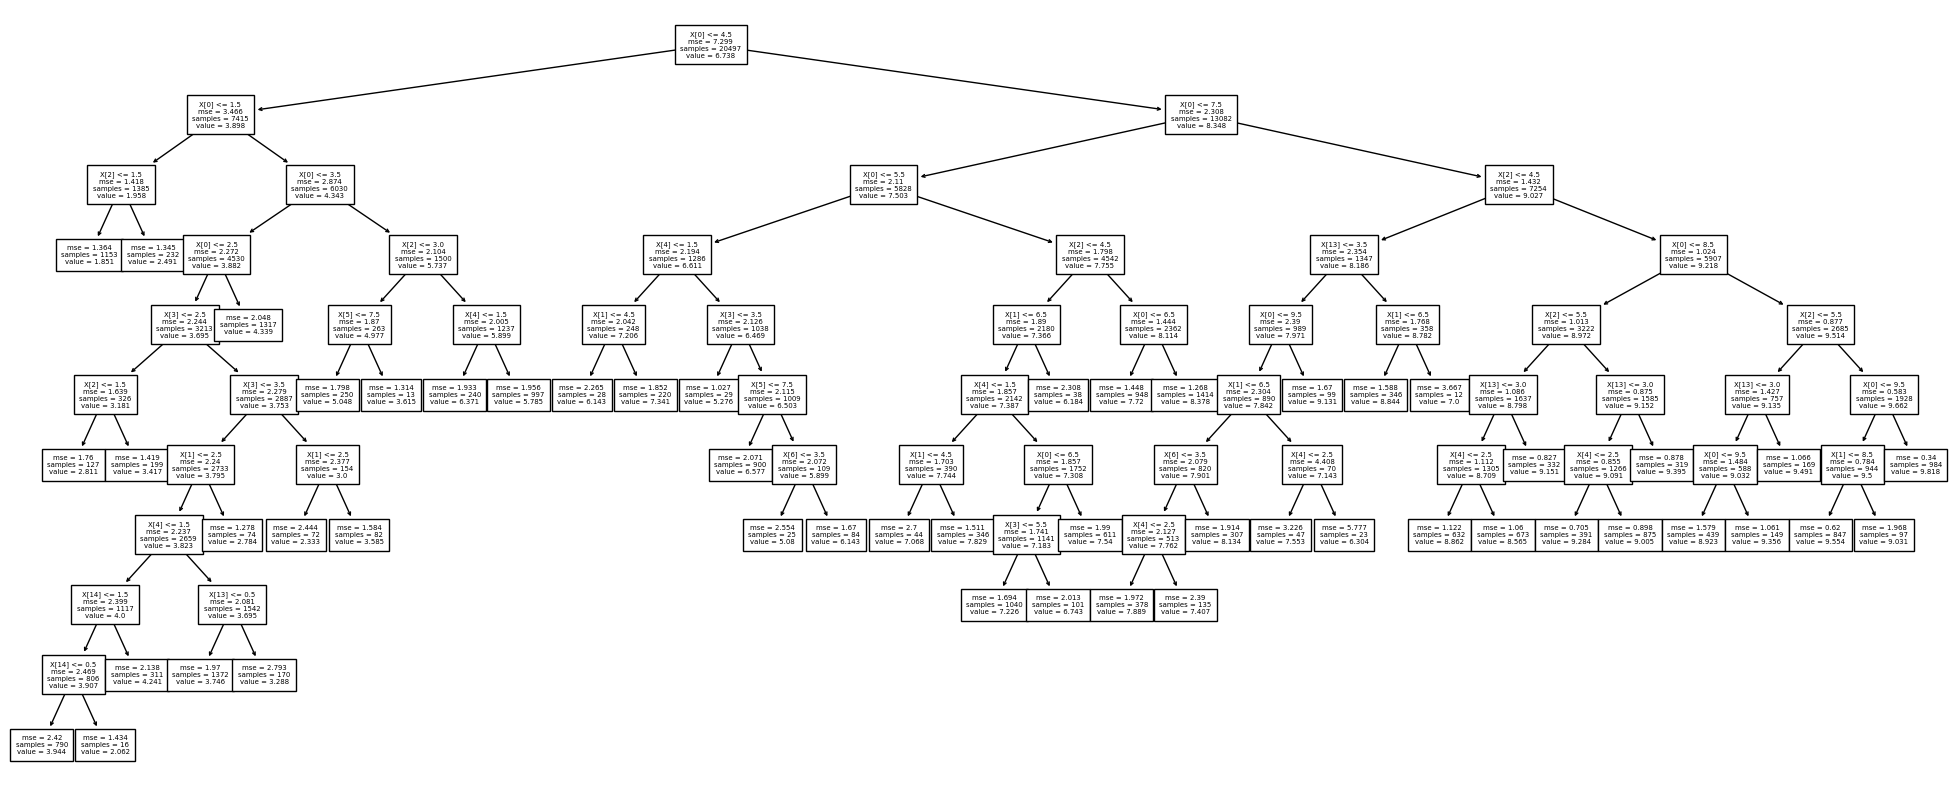

In [200]:
from sklearn import tree
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dtr_model = pickle.load(open('./model objects/decision_tree_model_best.pkl', 'rb'))

plt.figure(figsize=(25,10))
tree.plot_tree(dtr_model, fontsize=5)
plt.show()

In [203]:
dtr_model.feature_importances_

array([9.67388309e-01, 2.97046440e-03, 1.98853547e-02, 2.13484008e-03,
       3.32898723e-03, 5.93257025e-04, 4.08941298e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.60675487e-03, 6.83091239e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [204]:
dtr_importances = dtr_model.feature_importances_
#dtr_feature_names = dtr_model.feature_names_in_

## Feature importances from models

In [205]:
# for i in range(len(dtr_importances)):
#     print(dtr_feature_names[i], ':', dtr_importances[i])

In [207]:
# reg_coefs = reg.coef_
# reg_feature_names = reg.feature_names_in_
# regression_coefs = pd.DataFrame({'feature names':reg_feature_names,'coefficients':reg_coefs})
# regression_coefs

## Test results analysis

In [208]:
test_results = y.to_frame()
test_results['y_hat_reg'] = y_hat_reg
test_results['y_hat_svr'] = y_hat_svr
test_results['y_hat_dtr'] = y_hat_dtr
test_results['reg_squared_error'] = test_results.apply(lambda x: (x['raised_amount_buckets'] - x['y_hat_reg']) ** 2, axis = 1)
test_results['svr_squared_error'] = test_results.apply(lambda x: (x['raised_amount_buckets'] - x['y_hat_svr']) ** 2, axis = 1)
test_results['dtr_squared_error'] = test_results.apply(lambda x: (x['raised_amount_buckets'] - x['y_hat_dtr']) ** 2, axis = 1)
test_results['reg_rse'] = test_results.apply(lambda x: pow((x['raised_amount_buckets'] - x['y_hat_reg']) ** 2, 0.5), axis = 1)
test_results['svr_rse'] = test_results.apply(lambda x: pow((x['raised_amount_buckets'] - x['y_hat_svr']) ** 2, 0.5), axis = 1)
test_results['dtr_rse'] = test_results.apply(lambda x: pow((x['raised_amount_buckets'] - x['y_hat_dtr']) ** 2, 0.5), axis = 1)
test_results

,raised_amount_buckets,y_hat_reg,y_hat_svr,y_hat_dtr,reg_squared_error,svr_squared_error,dtr_squared_error,reg_rse,svr_rse,dtr_rse
0,6,4.188921,4.280798,4.338648,3.280007,2.955655,2.760089,1.811079,1.719202,1.661352
1,10,8.682075,8.899604,8.862342,1.736926,1.210870,1.294266,1.317925,1.100396,1.137658
2,8,7.012838,7.287411,7.225962,0.974489,0.507783,0.599136,0.987162,0.712589,0.774038
3,3,3.499000,3.192549,3.745627,0.249001,0.037075,0.555959,0.499000,0.192549,0.745627
4,3,3.499000,3.192549,3.745627,0.249001,0.037075,0.555959,0.499000,0.192549,0.745627
...,...,...,...,...,...,...,...,...,...,...
5644,6,4.972377,5.134694,4.338648,1.056009,0.748755,2.760089,1.027623,0.865306,1.661352
5646,5,3.557322,3.283419,3.944304,2.081320,2.946650,1.114494,1.442678,1.716581,1.055696
5647,5,3.557322,3.283419,3.944304,2.081320,2.946650,1.114494,1.442678,1.716581,1.055696
5648,2,4.449576,4.471211,4.338648,6.000425,6.106883,5.469277,2.449576,2.471211,2.338648


Null Hypothesis Testing

In [209]:
from scipy.stats import ttest_ind

_, p_value = ttest_ind(test_results['svr_squared_error'],test_results['dtr_squared_error'], equal_var = False )
print("p value is", p_value)
if p_value < 0.05:
    print('Reject the null hypothesis of equality in means of squared errors for SVR and Decision Tree result')
else:
    print('Fail to reject the null hypothesis of equality in means of squared errors for SVR and Decision Tree result')


p value is 0.3973727896878906
Fail to reject the null hypothesis of equality in means of squared errors for SVR and Decision Tree result


Mean Squared Error

In [211]:
index_mse = pd.DataFrame()
ind = []
reg_mse = []
svr_mse = []
dtr_mse = []
ind_freq = []

for i in range(10):
    index = test_results[test_results['raised_amount_buckets']==i+1]
    ind.append(i+1)
    reg_mse.append(index['reg_squared_error'].mean())
    svr_mse.append(index['svr_squared_error'].mean())
    dtr_mse.append(index['dtr_squared_error'].mean())
    ind_freq.append(len(index))

index_mse['index'] = ind
index_mse['reg'] = reg_mse
index_mse['svr'] = svr_mse
index_mse['dtr'] = dtr_mse
index_mse['frequency'] = ind_freq

In [212]:
index_mse

,index,reg,svr,dtr,frequency
0,1,4.924790,3.008948,3.035665,282
1,2,3.464157,2.873270,3.184581,247
2,3,1.919635,2.145474,2.275096,309
3,4,1.662626,2.355348,2.052912,399
4,5,2.895379,3.653922,2.981875,496
5,6,3.019891,3.684367,3.133292,494
6,7,1.993881,2.242043,1.922280,551
7,8,1.376291,1.165215,1.111709,679
8,9,1.447495,0.968084,1.124887,924
9,10,1.954480,1.281808,1.633836,970


Root Mean Squared Error

In [213]:
index_rmse = pd.DataFrame()
ind = []
reg_rmse = []
svr_rmse = []
dtr_rmse = []
ind_freq = []

for i in range(10):
    index = test_results[test_results['raised_amount_buckets']==i+1]
    ind.append(i+1)
    reg_rmse.append(index['reg_rse'].mean())
    svr_rmse.append(index['svr_rse'].mean())
    dtr_rmse.append(index['dtr_rse'].mean())
    ind_freq.append(len(index))

index_rmse['index'] = ind
index_rmse['reg_rmse'] = reg_rmse
index_rmse['svr_rmse'] = svr_rmse
index_rmse['dtr_rmse'] = dtr_rmse
index_rmse['frequency'] = ind_freq

In [214]:
index_rmse

,index,reg_rmse,svr_rmse,dtr_rmse,frequency
0,1,2.156188,1.537584,1.479416,282
1,2,1.628539,1.287361,1.424053,247
2,3,0.953801,0.963238,1.212634,309
3,4,0.867363,1.167610,0.947985,399
4,5,1.438640,1.667093,1.466085,496
5,6,1.434637,1.608833,1.485524,494
6,7,1.103301,1.193513,1.105610,551
7,8,0.938632,0.858142,0.829267,679
8,9,0.910828,0.692818,0.739333,924
9,10,1.119449,0.798395,0.954399,970


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f906c6b7-4fb3-42a0-9ffa-f1056dea520e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>